# Case Study - Pfizer

Before continuing with analysis of the dataset at large, here we will isolate Pfizer for a more detailed look. They are the company that logged the most number of rows in the larger dataset, meaning had the largest number of payments associated with them. Perhaps we can draw a few conclusions by looking at individual companies first, especially the largest ones.

In [49]:
#Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from sklearn import preprocessing
from sklearn import __version__ as sklearn_version
from sklearn.preprocessing import scale
from sklearn import tree
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.dummy import DummyRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.pipeline import make_pipeline
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.tree import DecisionTreeRegressor
import category_encoders as ce
import datetime
from scipy.stats import randint
from io import StringIO  
from IPython.display import Image  
import pydotplus

In [2]:
#Load data
cms_p = pd.read_csv('D:/Documents/Projects/Capstone1/Data_Edits/cms_pfizer1.csv', low_memory=False)

In [3]:
cms_p.head()

,Covered_Recipient_Type,Teaching_Hospital_ID,Physician_Profile_ID,Recipient_City,Recipient_State,Physician_Primary_Type,Physician_Specialty,Physician_License_State_code1,Physician_License_State_code2,Physician_License_State_code3,...,Name_of_Drug_or_Biological_or_Device_or_Medical_Supply_4,Associated_Drug_or_Biological_NDC_4,Covered_or_Noncovered_Indicator_5,Indicate_Drug_or_Biological_or_Device_or_Medical_Supply_5,Product_Category_or_Therapeutic_Area_5,Name_of_Drug_or_Biological_or_Device_or_Medical_Supply_5,Associated_Drug_or_Biological_NDC_5,Program_Year,Recipient_ID,month
0,Covered Recipient Physician,NaN,895773.0,AGUADILLA,PR,Medical Doctor,Allopathic & Osteopathic Physicians|Internal M...,PR,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019,p895773.0,1
1,Covered Recipient Physician,NaN,243055.0,BAYAMON,PR,Medical Doctor,Allopathic & Osteopathic Physicians|Family Med...,PR,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019,p243055.0,1
2,Covered Recipient Physician,NaN,363902.0,SAN JUAN,PR,Medical Doctor,Allopathic & Osteopathic Physicians|Internal M...,PR,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019,p363902.0,1
3,Covered Recipient Physician,NaN,1255293.0,SAN JUAN,PR,Medical Doctor,Allopathic & Osteopathic Physicians|Internal M...,PR,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019,p1255293.0,2
4,Covered Recipient Physician,NaN,725791.0,FAJARDO,PR,Medical Doctor,Allopathic & Osteopathic Physicians|Internal M...,PR,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019,p725791.0,3


In [4]:
cms_p.shape

(511645, 58)

In [5]:
#to Datetime
cms_p['Date_of_Payment'] = pd.to_datetime(cms_p['Date_of_Payment'])
cms_p.dtypes

Covered_Recipient_Type                                                       object
Teaching_Hospital_ID                                                        float64
Physician_Profile_ID                                                        float64
Recipient_City                                                               object
Recipient_State                                                              object
Physician_Primary_Type                                                       object
Physician_Specialty                                                          object
Physician_License_State_code1                                                object
Physician_License_State_code2                                               float64
Physician_License_State_code3                                               float64
Physician_License_State_code4                                               float64
Physician_License_State_code5                                               

In [55]:
#Why do there seem to be multiple senders? Is this significant?
cms_p['Applicable_Manufacturer_or_Applicable_GPO_Making_Payment_ID'].value_counts()

100000000286    507479
100000401810      1873
100000000294      1832
100000000167       203
100000005445       121
100000010858        93
100000471812        11
100000000307        11
100000151635         5
100000136499         4
100000211779         4
100000061396         2
100000000323         1
100000000334         1
100000000303         1
100000000317         1
100000476811         1
100000071377         1
100000211780         1
Name: Applicable_Manufacturer_or_Applicable_GPO_Making_Payment_ID, dtype: int64

In [56]:
cms_p['Applicable_Manufacturer_or_Applicable_GPO_Making_Payment_State'].value_counts()

NY    507698
PR      3705
IL       121
CA        98
MI        13
NC         5
MD         1
MA         1
Name: Applicable_Manufacturer_or_Applicable_GPO_Making_Payment_State, dtype: int64

The issue of "multiple payment maker IDs" seems closely tied to geography. Perhaps the few additional IDs are due to the locations being outside the USA but still controlled by Pfizer.

Since Datetime will not work in our ML algorithm, instead of using the raw datetime object, several features, namely month, quarter, and weekday, will be extracted from it that can be encoded properly. (Year would also be a useful feature if we were looking at Pfizer's 2019 data in addition to other years.) From examining the 'Date_of_Payment' column, it is known that none of its values are missing, and it is formatted 'mm/dd/yyyy'. But since every column currently will be encoded, this date column will be dropped for the sake of space in favor of its features.

In [6]:
cms_p['Date_of_Payment'] = cms_p['Date_of_Payment'].dt.strftime('%m.%d.%y')
cms_p['month'] = pd.DatetimeIndex(cms_p['Date_of_Payment']).month
cms_p['dayofweek'] = pd.DatetimeIndex(cms_p['Date_of_Payment']).weekday
cms_p['quarter'] = pd.DatetimeIndex(cms_p['Date_of_Payment']).quarter

In [7]:
#Now to drop "Date of Payment"
cms_p = cms_p.drop(['Date_of_Payment'],axis=1)

In [8]:
cms_p.dtypes

Covered_Recipient_Type                                                object
Teaching_Hospital_ID                                                 float64
Physician_Profile_ID                                                 float64
Recipient_City                                                        object
Recipient_State                                                       object
Physician_Primary_Type                                                object
Physician_Specialty                                                   object
Physician_License_State_code1                                         object
Physician_License_State_code2                                        float64
Physician_License_State_code3                                        float64
Physician_License_State_code4                                        float64
Physician_License_State_code5                                        float64
Submitting_Applicable_Manufacturer_or_Applicable_GPO_Name             object

## Data Exploration

Who or where is Pfizer paying the most?

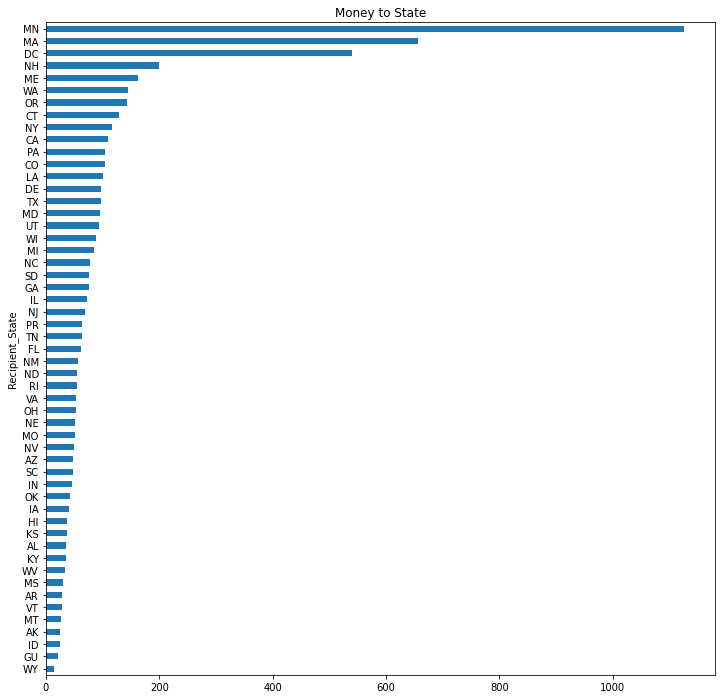

In [9]:
company_payment_mean = cms_p.groupby('Recipient_State')['Total_Amount_of_Payment_USDollars'].mean()

#Plotting money going to states
company_payment_mean.sort_values().plot(kind='barh', figsize=(12, 12), title = 'Money to State');

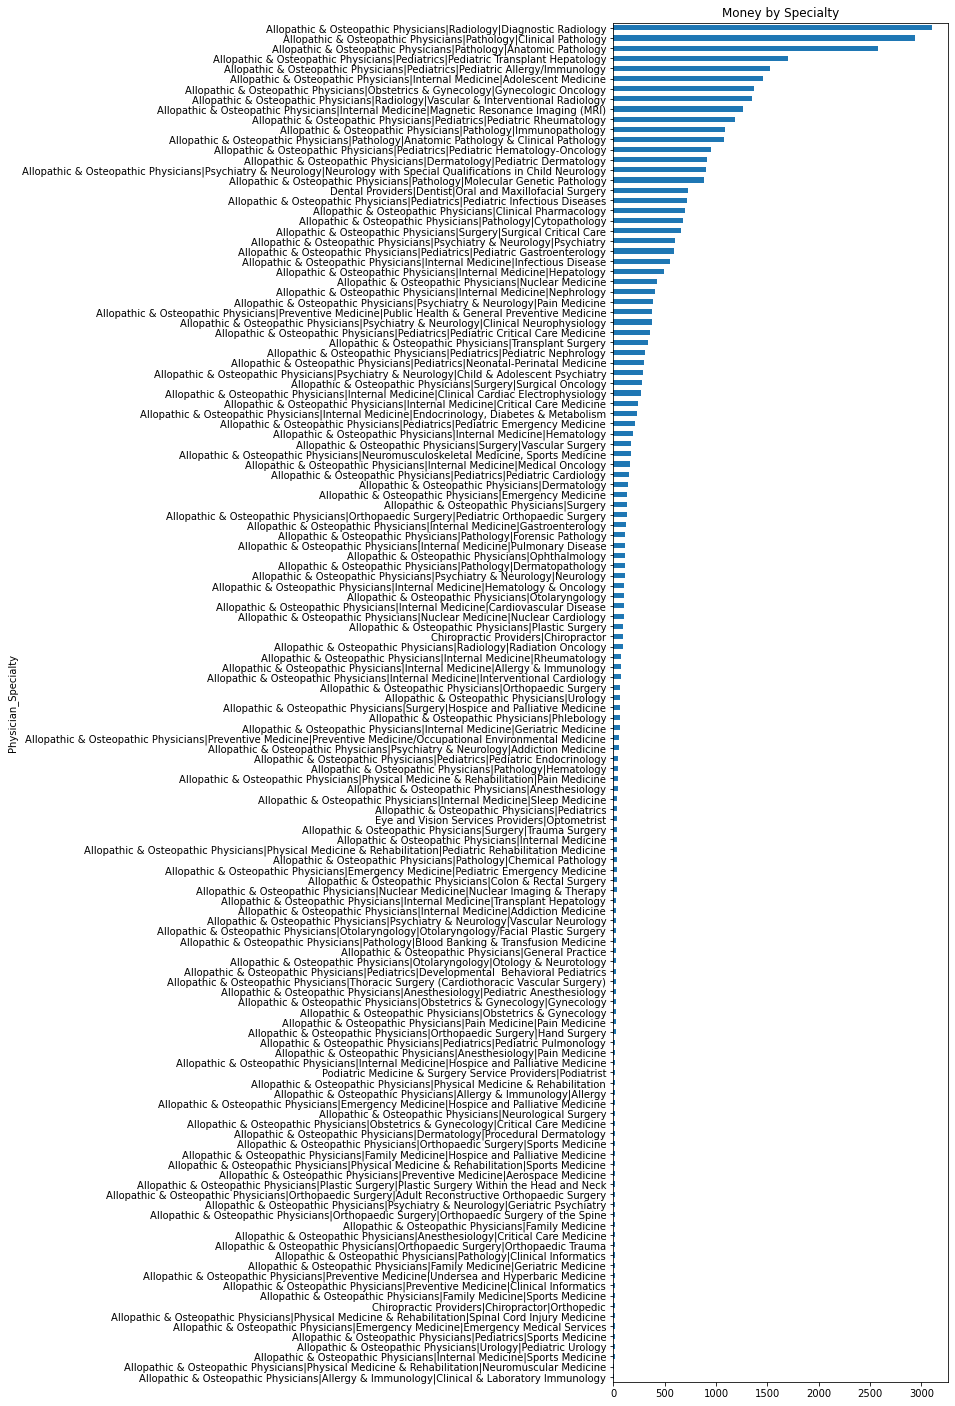

In [10]:
company_payment_mean1 = cms_p.groupby('Physician_Specialty')['Total_Amount_of_Payment_USDollars'].mean()

#Plotting money going to specialties
company_payment_mean1.sort_values().plot(kind='barh', figsize=(6, 25), title = 'Money by Specialty');

In [11]:
company_payment_mean1.sort_values(ascending=False).head(20)

Physician_Specialty
Allopathic & Osteopathic Physicians|Radiology|Diagnostic Radiology                                                     3104.213694
Allopathic & Osteopathic Physicians|Pathology|Clinical Pathology                                                       2936.000000
Allopathic & Osteopathic Physicians|Pathology|Anatomic Pathology                                                       2574.515000
Allopathic & Osteopathic Physicians|Pediatrics|Pediatric Transplant Hepatology                                         1702.005000
Allopathic & Osteopathic Physicians|Pediatrics|Pediatric Allergy/Immunology                                            1527.091455
Allopathic & Osteopathic Physicians|Internal Medicine|Adolescent Medicine                                              1456.978421
Allopathic & Osteopathic Physicians|Obstetrics & Gynecology|Gynecologic Oncology                                       1372.052800
Allopathic & Osteopathic Physicians|Radiology|Vascular & Interv

It seems that there seem to be "overlaps" in categories - for instance, the specialty "allopathic and osteopathic physicians" shows up over every bar here. There may be ways to categorize these specialties in a more efficient manner. However, these categories will be kept as is in terms of this project because of two reasons. First, perhaps there are contextual reasons that these categories are listed as so, and switching them around would lose some meaning and organization. Secondly, this dataset is still part of the larger 2019 general payments dataset, which would contain all these labels and more.

In [12]:
#Which hospitals is Pfizer paying the most? 
company_payment_mean2 = cms_p.groupby('Teaching_Hospital_ID')['Total_Amount_of_Payment_USDollars'].mean()

company_payment_mean2.sort_values(ascending=False).head(25)

Teaching_Hospital_ID
7728.0    156750.000000
7340.0    153847.000000
7310.0    139862.000000
7412.0    102166.666667
7736.0     75300.000000
7338.0     71289.333333
7580.0     54083.333333
8281.0     52500.000000
7820.0     50000.000000
8288.0     44345.955714
8074.0     43528.000000
7799.0     41060.440000
7874.0     38275.555556
7474.0     38226.363636
7829.0     37944.888889
7552.0     37583.333333
7601.0     36500.000000
8319.0     35210.000000
8614.0     32687.500000
8005.0     26016.666667
7408.0     25000.000000
7368.0     25000.000000
7754.0     24500.000000
7561.0     20350.740800
8581.0     18610.000000
Name: Total_Amount_of_Payment_USDollars, dtype: float64

In [13]:
#What about physician?
company_payment_mean3 = cms_p.groupby('Physician_Profile_ID')['Total_Amount_of_Payment_USDollars'].mean()

company_payment_mean3.sort_values(ascending=False).head(25)

Physician_Profile_ID
479314.0     100000.0000
2558109.0    100000.0000
1213447.0     98000.0000
1287538.0     82652.6400
121550.0      80000.0000
7230771.0     47000.0000
852736.0      46992.0000
7086056.0     43803.5000
4221004.0     40000.0000
738572.0      35650.0000
1132865.0     33750.0000
711482.0      33333.3300
211802.0      29690.0000
1116920.0     25506.3600
5422655.0     25010.7100
663687.0      25000.0000
224277.0      21300.0000
5706379.0     20058.6700
349563.0      19854.3725
251671.0      19531.2400
1152334.0     19172.5000
249435.0      16992.0000
2790432.0     16887.0350
1131143.0     16200.0000
157768.0      15625.0000
Name: Total_Amount_of_Payment_USDollars, dtype: float64

In [14]:
#What about looking at sums? 
company_payment_sum2 = cms_p.groupby('Teaching_Hospital_ID')['Total_Amount_of_Payment_USDollars'].sum()

company_payment_sum2.sort_values(ascending=False).head(25)

Teaching_Hospital_ID
7340.0    1538470.00
7561.0     508768.52
8336.0     465700.00
7474.0     420490.00
7874.0     344480.00
7829.0     341504.00
8288.0     310421.69
7412.0     306500.00
8581.0     297760.00
8100.0     294300.00
7754.0     294000.00
8575.0     264825.00
8614.0     261500.00
7327.0     232336.88
7552.0     225500.00
7338.0     213868.00
8588.0     207297.50
8457.0     193857.00
8579.0     162771.25
7580.0     162250.00
7728.0     156750.00
8005.0     156100.00
7736.0     150600.00
7310.0     139862.00
8281.0     105000.00
Name: Total_Amount_of_Payment_USDollars, dtype: float64

In [15]:
#What about physician?
company_payment_sum3 = cms_p.groupby('Physician_Profile_ID')['Total_Amount_of_Payment_USDollars'].sum()

company_payment_sum3.sort_values(ascending=False).head(25)

Physician_Profile_ID
1152334.0    613520.00
148368.0     489310.00
489893.0     449206.73
176949.0     230365.00
956640.0     226943.60
119303.0     221182.74
59755.0      212805.35
700284.0     174743.27
954057.0     171118.81
367624.0     160360.00
1113252.0    150291.73
457253.0     131295.00
620680.0     128698.88
902571.0     127650.56
291612.0     127623.74
35882.0      124066.22
927768.0     122000.00
48969.0      120734.75
211802.0     118760.00
148068.0     118583.01
339077.0     114811.59
1214613.0    111195.00
273257.0     110682.60
157256.0     106843.69
69343.0      103239.41
Name: Total_Amount_of_Payment_USDollars, dtype: float64

For our purposes, the actual names of the hospitals and physicians receiving the most money is not too important. That can be looked up by going back to the original dataset that contains the names of all recipients. What is important is the comparison between the two categories of recipients. Hospitals receive higher average payments, but the highest averages are within the same order of magnitude. The comparison of payment sums actually reveals that the amount going to the top few physicians is actually not too different than the the amount going to the top hospitals, but hospitals still receive larger payments overall.

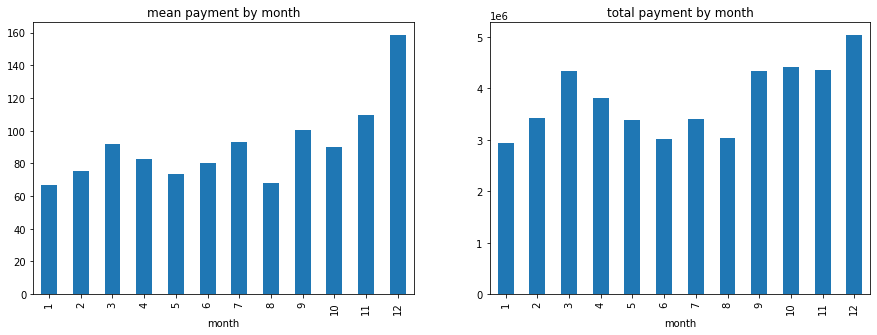

In [16]:
#When are most payments being done?
plt.subplot(1,2,1)
cms_p.groupby('month')['Total_Amount_of_Payment_USDollars'].mean().plot(kind='bar',figsize=(15,5),title='mean payment by month');

plt.subplot(1,2,2)
cms_p.groupby('month')['Total_Amount_of_Payment_USDollars'].sum().plot(kind='bar',figsize=(15,5),title='total payment by month');

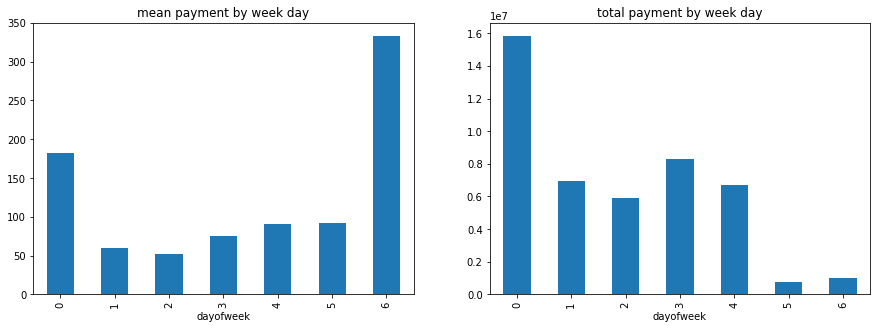

In [17]:
plt.subplot(1,2,1)
cms_p.groupby('dayofweek')['Total_Amount_of_Payment_USDollars'].mean().plot(kind='bar',figsize=(15,5),title='mean payment by week day');

plt.subplot(1,2,2)
cms_p.groupby('dayofweek')['Total_Amount_of_Payment_USDollars'].sum().plot(kind='bar',figsize=(15,5),title='total payment by week day');

On a different note, unfortunately, assuming a similar distribution to the whole data set, Pfizer will contain extreme outliers in payment values, too. Let's check for that.

In [18]:
cms_p['Total_Amount_of_Payment_USDollars'].describe()

count    511645.000000
mean         88.873453
std        2189.462087
min           0.010000
25%           9.150000
50%          12.820000
75%          16.060000
max      728160.000000
Name: Total_Amount_of_Payment_USDollars, dtype: float64

In [19]:
cms_p[cms_p['Total_Amount_of_Payment_USDollars']>343.73]['Recipient_ID'].count()

11566

In [20]:
11566/511645

0.02260551749748361

2.2% of values reside above the mean *from the larger data set* within this data set. There is quite a spread in the payment values as the minimum payment is $0.01, and the maximum is 700k.

In [21]:
#Dropping these two columns - this information is repeated in the comprehensive column Recipient ID
cms_p = cms_p.drop(
    ['Teaching_Hospital_ID',
     'Physician_Profile_ID',
    ],axis=1
)

In [22]:
cms_p.shape

(511645, 57)

In [23]:
#cms_p1 = cms_p

In [24]:
#Adding "new category" for category columns
#change_cols = [
#    'Covered_Recipient_Type',
#    'Recipient_State',
#    'Physician_Primary_Type',
#    'Physician_License_State_code1',
#    'Physician_License_State_code2',
#    'Physician_License_State_code3',
#    'Physician_License_State_code4',
#    'Physician_License_State_code5',
#    'Applicable_Manufacturer_or_Applicable_GPO_Making_Payment_State',
#    'Applicable_Manufacturer_or_Applicable_GPO_Making_Payment_Country',
#    'Nature_of_Payment_or_Transfer_of_Value',
#    'State_of_Travel',
#    'Country_of_Travel',
#    'Physician_Ownership_Indicator',
#    'Third_Party_Payment_Recipient_Indicator',
#    'Charity_Indicator',
#    'Third_Party_Equals_Covered_Recipient_Indicator',
#    'Related_Product_Indicator'
#    ]

#cms_p1[change_cols] = cms_p1[change_cols].astype('category')

In [23]:
#for cols in change_cols:
#    cms_p1[cols] = cms_p1[cols].cat.add_categories('Blank')

In [24]:
#Dealing with null values by changing them to the string "Blank"
#def impute_nan(df,col):
#    df[col] = np.where(df[col].isnull(),'Blank',df[col])
#
#for col in cms_p1.columns:
#    impute_nan(cms_p1,col)
    
#cms_p1.head()

,Covered_Recipient_Type,Teaching_Hospital_ID,Physician_Profile_ID,Recipient_City,Recipient_State,Physician_Primary_Type,Physician_Specialty,Physician_License_State_code1,Physician_License_State_code2,Physician_License_State_code3,...,Covered_or_Noncovered_Indicator_5,Indicate_Drug_or_Biological_or_Device_or_Medical_Supply_5,Product_Category_or_Therapeutic_Area_5,Name_of_Drug_or_Biological_or_Device_or_Medical_Supply_5,Associated_Drug_or_Biological_NDC_5,Program_Year,Recipient_ID,month,dayofweek,quarter
0,Covered Recipient Physician,Blank,895773.0,AGUADILLA,PR,Medical Doctor,Allopathic & Osteopathic Physicians|Internal M...,PR,Blank,Blank,...,Blank,Blank,Blank,Blank,Blank,2019,p895773.0,1,0,1
1,Covered Recipient Physician,Blank,243055.0,BAYAMON,PR,Medical Doctor,Allopathic & Osteopathic Physicians|Family Med...,PR,Blank,Blank,...,Blank,Blank,Blank,Blank,Blank,2019,p243055.0,1,0,1
2,Covered Recipient Physician,Blank,363902.0,SAN JUAN,PR,Medical Doctor,Allopathic & Osteopathic Physicians|Internal M...,PR,Blank,Blank,...,Blank,Blank,Blank,Blank,Blank,2019,p363902.0,1,4,1
3,Covered Recipient Physician,Blank,1255293.0,SAN JUAN,PR,Medical Doctor,Allopathic & Osteopathic Physicians|Internal M...,PR,Blank,Blank,...,Blank,Blank,Blank,Blank,Blank,2019,p1255293.0,2,0,1
4,Covered Recipient Physician,Blank,725791.0,FAJARDO,PR,Medical Doctor,Allopathic & Osteopathic Physicians|Internal M...,PR,Blank,Blank,...,Blank,Blank,Blank,Blank,Blank,2019,p725791.0,3,2,1


## Preprocessing and Training

In [25]:
X = cms_p.drop(columns='Total_Amount_of_Payment_USDollars')
y = cms_p.Total_Amount_of_Payment_USDollars

In [26]:
len(X) * .7, len(X) * .3

(358151.5, 153493.5)

In [27]:
y.describe()

count    511645.000000
mean         88.873453
std        2189.462087
min           0.010000
25%           9.150000
50%          12.820000
75%          16.060000
max      728160.000000
Name: Total_Amount_of_Payment_USDollars, dtype: float64

In [28]:
#encoding for categorical data before using sklearn's regressors
encoder_B = ce.BinaryEncoder()
X_tf = encoder_B.fit_transform(X)

C:\Users\Max\anaconda3\lib\site-packages\category_encoders\utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


In [29]:
X_tf.head()

,Covered_Recipient_Type_0,Covered_Recipient_Type_1,Recipient_City_0,Recipient_City_1,Recipient_City_2,Recipient_City_3,Recipient_City_4,Recipient_City_5,Recipient_City_6,Recipient_City_7,...,Recipient_ID_11,Recipient_ID_12,Recipient_ID_13,Recipient_ID_14,Recipient_ID_15,Recipient_ID_16,Recipient_ID_17,month,dayofweek,quarter
0,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,1,0,1
1,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,1,0,1
2,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,1,1,4,1
3,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,2,0,1
4,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,1,3,2,1


In [30]:
X_train, X_test, y_train, y_test = train_test_split(X_tf,y,
                                                    test_size=0.3, 
                                                    random_state=1)

In [31]:
X_train.shape

(358151, 256)

In [32]:
X_train.dtypes

Covered_Recipient_Type_0    int64
Covered_Recipient_Type_1    int64
Recipient_City_0            int64
Recipient_City_1            int64
Recipient_City_2            int64
                            ...  
Recipient_ID_16             int64
Recipient_ID_17             int64
month                       int64
dayofweek                   int64
quarter                     int64
Length: 256, dtype: object

In [33]:
y_train.shape

(358151,)

In [34]:
y_train.min(),y_train.max()

(0.01, 728160.0)

In [35]:
# Quick baseline - prediction using the mean
y_train.mean()

87.59158385708449

In [36]:
dumb_reg = DummyRegressor(strategy='mean')
dumb_reg.fit(X_train, y_train)
dumb_reg.constant_

array([[87.59158386]])

In [37]:
# Making arrays the length of the training / test sets respectively with only the training set mean as the value
y_tr_pred = dumb_reg.predict(X_train)
y_te_pred = 87.59158386 * np.ones(len(y_test))

In [38]:
# Baseline evaluation of performance using MSE
mean_squared_error(y_train, y_tr_pred), mean_squared_error(y_test, y_te_pred)

(4407965.4754074635, 5693864.719134784)

In [40]:
y_tr_pred

array([87.59158386, 87.59158386, 87.59158386, ..., 87.59158386,
       87.59158386, 87.59158386])

In [ ]:
#plot(y_train,kind='line') - what is the distribution of y-train?

In [41]:
# making decision tree
dtree = DecisionTreeRegressor(criterion='mse',random_state=42)
dtree.fit(X_train,y_train)
y_pred = dtree.predict(X_test)
dtree

DecisionTreeRegressor(ccp_alpha=0.0, criterion='mse', max_depth=None,
                      max_features=None, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, presort='deprecated',
                      random_state=42, splitter='best')

In [42]:
# How did it do according to MSE?
mean_squared_error(y_test,y_pred)

2517552.143671001

In [ ]:
#Normalize: sqrt, then Divide by mean of data set

In [ ]:
#Visualization attempt using graphviz
#from sklearn.tree import export_graphviz
#from sklearn.externals.six import StringIO  
#from IPython.display import Image  
#import pydotplus

#dot_data = StringIO()
#export_graphviz(dtree, out_file=dot_data,  
#                filled=True, rounded=True,
#                special_characters=True,feature_names = X_df_tf.columns)
#graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
#graph.write_png('pfizer_dtree1.png')
#Image(graph.create_png())

Creating a basic decision tree to predict payments improved predictions versus simply using the mean, as measured through MSE. However the large outliers most certainly would contribute to having such a high MSE in both cases. Perhaps also the sparcity of many columns (for example, "Physician Specialty 5") is affecting the decision tree's ability to predict, as trees are biased toward columns that contain more values. In any case, let's try removing the highest outliers and retraining the models. If going forward this is how the model is constructed, it will unfortunately be limited by being unable to predict those (few and far between) extremely high values. But before then, let's see if a random forest model offers any improvement.

In [43]:
#Using a random forest model
RFR = RandomForestRegressor()
RFR.fit(X_train,y_train)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=None, oob_score=False,
                      random_state=None, verbose=0, warm_start=False)

In [44]:
# using model to make predictions?
y_pred = RFR.predict(X_test)
mean_squared_error(y_test,y_pred)

2945094.6807798157

40


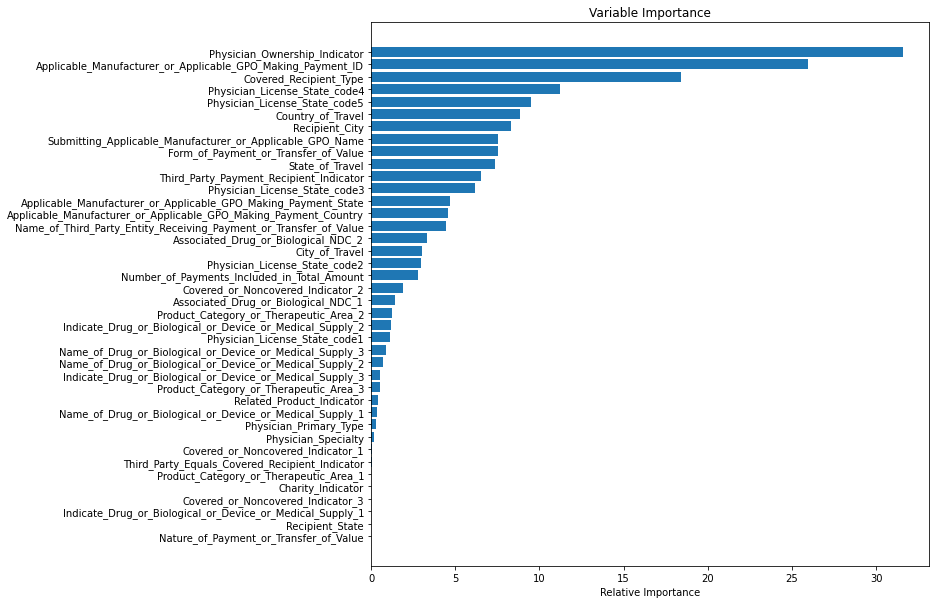

In [59]:
# A look at feature importances; code taken from the Springboard RandomForest case study (link)
feature_importance = RFR.feature_importances_
# make importances relative to max importance
feature_importance = 100.0 * (feature_importance / feature_importance.max())[:40]
sorted_idx = np.argsort(feature_importance)[:40]

pos = np.arange(sorted_idx.shape[0]) + .5
print(pos.size)
sorted_idx.size
plt.figure(figsize=(10,10))
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, X.columns[sorted_idx])
plt.xlabel('Relative Importance')
plt.title('Variable Importance')
plt.show()

The random forest model has curiously performed slightly worse than a single decision tree. Looking at its most important features also reveals a troubling result: the model is putting much more importance on certain (but not all) features with limited value counts. For example, here the only "Submitting Applicable Manufacturer" should be Pfizer. (Though it should be noted that within the larger data set containing all companies' payments, this probably holds true.) The "Physician Ownership Indicator" contains more than 99% answers as "No", and the remaining less than 1% are split between "Yes" and null values. Perhaps dropping these columns can help our model achieve better clarity on what other factors may be more important.

## Round 2

For our next trial, let's drop the outliers - cutting out the values over the mean still gives us all values up to almost a 98%th percentile - and let's drop some of those columns of questionable usage. Then let's run a few simple models and compare MSE again.

In [64]:
cms_p1 = cms_p[cms_p['Total_Amount_of_Payment_USDollars']<=343.73]

In [65]:
cms_p1.shape

(500079, 57)

In [82]:
cms_p1['Total_Amount_of_Payment_USDollars'].describe()

count    500079.000000
mean         17.154594
std          28.393057
min           0.010000
25%           8.940000
50%          12.700000
75%          15.740000
max         343.600000
Name: Total_Amount_of_Payment_USDollars, dtype: float64

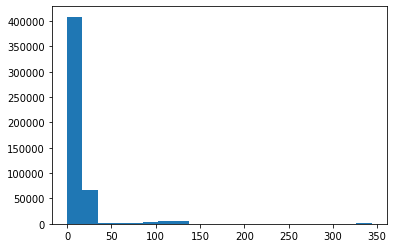

In [81]:
plt.hist(cms_p1['Total_Amount_of_Payment_USDollars'], bins=20);

In [86]:
cms_p1[cms_p1['Total_Amount_of_Payment_USDollars']>300]

,Covered_Recipient_Type,Recipient_City,Recipient_State,Physician_Primary_Type,Physician_Specialty,Physician_License_State_code1,Physician_License_State_code2,Physician_License_State_code3,Physician_License_State_code4,Physician_License_State_code5,...,Covered_or_Noncovered_Indicator_5,Indicate_Drug_or_Biological_or_Device_or_Medical_Supply_5,Product_Category_or_Therapeutic_Area_5,Name_of_Drug_or_Biological_or_Device_or_Medical_Supply_5,Associated_Drug_or_Biological_NDC_5,Program_Year,Recipient_ID,month,dayofweek,quarter
15,Covered Recipient Physician,BOSTON,MA,Medical Doctor,Allopathic & Osteopathic Physicians|Pediatrics,MA,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,2019,p222180.0,6,4,2
53,Covered Recipient Physician,BALTIMORE,MD,Medical Doctor,Allopathic & Osteopathic Physicians|Preventive...,MD,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,2019,p146375.0,3,1,1
84,Covered Recipient Physician,ST PETERSBURG,FL,Medical Doctor,Allopathic & Osteopathic Physicians|Internal M...,FL,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,2019,p150934.0,5,5,2
105,Covered Recipient Physician,ARLINGTON,VA,Medical Doctor,Allopathic & Osteopathic Physicians|Internal M...,VA,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,2019,p814754.0,6,6,2
124,Covered Recipient Physician,NEW YORK,NY,Medical Doctor,Allopathic & Osteopathic Physicians|Internal M...,NY,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,2019,p1244645.0,3,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
508262,Covered Recipient Physician,ORANGE,CA,Medical Doctor,Allopathic & Osteopathic Physicians|Internal M...,CA,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,2019,p1263308.0,5,2,2
508960,Covered Recipient Physician,WALNUT CREEK,CA,Medical Doctor,Allopathic & Osteopathic Physicians|Internal M...,CA,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,2019,p356221.0,10,4,4
510082,Covered Recipient Physician,CHICAGO,IL,Medical Doctor,Allopathic & Osteopathic Physicians|Otolaryngo...,IL,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,2019,p273840.0,5,0,2
510521,Covered Recipient Physician,PHILADELPHIA,PA,Medical Doctor,Allopathic & Osteopathic Physicians|Dermatology,DE,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,2019,p515635.0,7,2,3


It would seem that the distribution of this data set is very skewed toward the left. Even after cutting roughly 10k points higher than 343, in this remaining subset we still have 1177 transactions between 300 and 343 while over 400k remaining rows remain below 25.

In [67]:
cms_p1.drop([
    'Physician_Ownership_Indicator',
    'Submitting_Applicable_Manufacturer_or_Applicable_GPO_Name'
],axis=1,inplace=True)

C:\Users\Max\anaconda3\lib\site-packages\pandas\core\frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [68]:
cms_p1.shape

(500079, 55)

In [69]:
# Reorganizing our train/ test data
X1 = cms_p1.drop(columns='Total_Amount_of_Payment_USDollars')
y1 = cms_p1.Total_Amount_of_Payment_USDollars

In [70]:
encoder_B1 = ce.BinaryEncoder()
X_tf1 = encoder_B1.fit_transform(X1)

C:\Users\Max\anaconda3\lib\site-packages\category_encoders\utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


In [71]:
X_train1, X_test1, y_train1, y_test1 = train_test_split(X_tf1,y1,
                                                    test_size=0.3, 
                                                    random_state=1)

In [72]:
#Basic Decision Tree
dtree1 = DecisionTreeRegressor(criterion='mse',random_state=42)
dtree1.fit(X_train1,y_train1)
y_pred1 = dtree1.predict(X_test1)
dtree1

DecisionTreeRegressor(ccp_alpha=0.0, criterion='mse', max_depth=None,
                      max_features=None, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, presort='deprecated',
                      random_state=42, splitter='best')

In [74]:
mean_squared_error(y_test1,y_pred1)

650.5328701886028

Huge improvement from before!

In [75]:
#RFR
RFR1 = RandomForestRegressor()
RFR1.fit(X_train1,y_train1)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=None, oob_score=False,
                      random_state=None, verbose=0, warm_start=False)

In [76]:
# using model to make predictions?
y_predrf1 = RFR1.predict(X_test1)
mean_squared_error(y_test1,y_pred1)

650.5328701886028

sdaf

40


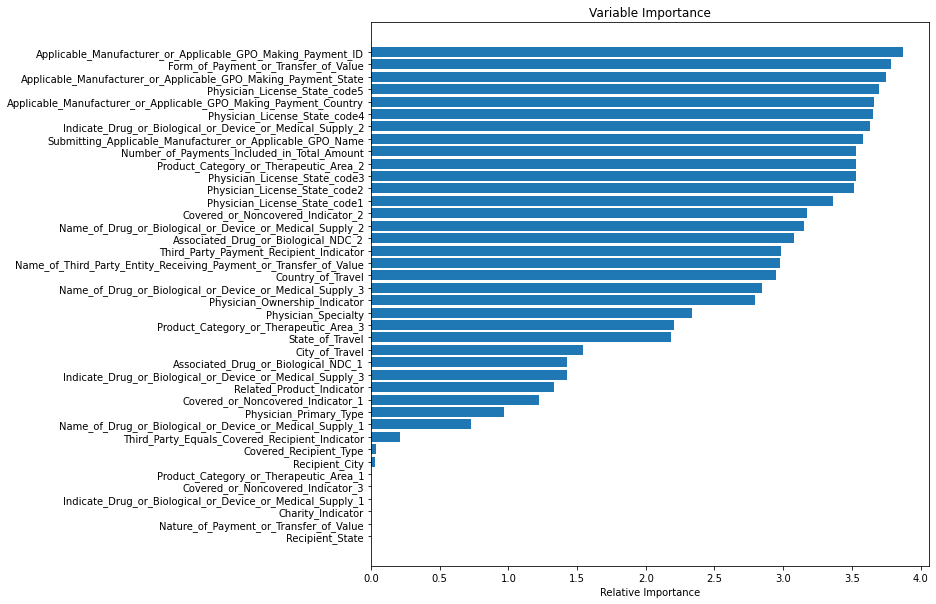

In [77]:
feature_importance = RFR1.feature_importances_
# make importances relative to max importance
feature_importance = 100.0 * (feature_importance / feature_importance.max())[:40]
sorted_idx = np.argsort(feature_importance)[:40]

pos = np.arange(sorted_idx.shape[0]) + .5
print(pos.size)
sorted_idx.size
plt.figure(figsize=(10,10))
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, X.columns[sorted_idx])
plt.xlabel('Relative Importance')
plt.title('Variable Importance')
plt.show()

In [78]:
#5-fold cross-validation for some hyperparameter tuning?
param_dist = {
    "max_depth":[10,None],
    "max_features":["auto", "sqrt", "log2"],
    "min_samples_leaf":randint(1,9)
}

RFR1_cv = RandomizedSearchCV(RFR1, param_dist, cv=5)
RFR1_cv.fit(X_train1,y_train1)

KeyboardInterrupt: 

In [ ]:
print(RFR1_cv.best_params_)

In [ ]:
#n_est = [int(n) for n in np.logspace(start=1, stop=3, num=20)]
#grid_params = {
#        'randomforestregressor__n_estimators': n_est,
#        'standardscaler': [StandardScaler(), None],
#        'simpleimputer__strategy': ['mean', 'median']
#}
#grid_params